In [1]:
%matplotlib notebook

In [2]:
import torch
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

from pinn_kit import *

In [3]:
# TQDM for progress bars
from tqdm.notebook import tqdm
# Autoreload changes to pinn_kit.py and other modules
%load_ext autoreload
%autoreload 2

## Coordinate Names \& Properties

In [4]:
# Names & properties
coords = {"x": (1,), "t": (1,)}

# Coordinate domain
x_min = -1.0
x_max = 1.0
t_min = 0.0
t_max = 1.0

## Map input to a circle to impose circular domain topology

In [5]:
def circle(circle_positions):
    angle = circle_positions*2*np.pi
    return (torch.sin(angle), torch.cos(angle))
in_map = InputRemap(coords, lambda crds: ((crds["t"]-t_min)/(t_max-t_min), *circle((crds["x"]-x_min)/(x_max-x_min))))

## Initial Condition Definition
Must be defined via a callable function.
Note: this function must naturally obey domain constraints!

In [6]:
def u_0(x):
    return -torch.sin(np.pi*((2.*(x-x_min)/(x_max-x_min))-1.))

## Map output to guarantee initial condition is obeyed at $t=0$
This is more art than science, but my best guess is that, since NNs learn low-frequency features more easily than high-frequency ones, it will be safest to slowly, smoothly impose the initial data, and if a more aggressive shift away from the boundary conditions is needed the network will learn it with enough training.

In [7]:
def crossfade(speed, times, A_vals, B_vals):
    B_weights = torch.tanh(times*speed)
    A_weights = 1.-B_weights
    return A_weights*A_vals + B_weights*B_vals

out_map = OutputRemap(coords, (torch.Size((1,)),), lambda crds, vrs: {"u" : crossfade(2., crds["t"], u_0(crds["x"]), vrs[0])})

## Create a trainable solution forced to obey boundary and initial conditions
For now, I will just use the classic PINN architecture, although there probably exist better choices.

In [8]:
solution = ClassicPINN(in_map, out_map, device='cuda:2')

## Equation Definition

In [9]:
# For convenience, define sympy symbols for the coordinates & variables.
x_sym, t_sym, u_sym = sp.symbols("x t u")

In [10]:
burgers_eq_sym = sp.Derivative(u_sym, t_sym) \
             + u_sym * sp.Derivative(u_sym, x_sym) \
             - (0.01 / 3.14) * sp.Derivative(u_sym, x_sym, 2);
burgers_eq_sym

u*Derivative(u, x) + Derivative(u, t) - 0.00318471337579618*Derivative(u, (x, 2))

In [11]:
# Now we create the equation that the PINN will try to solve
burgers_eq = Equation(solution, burgers_eq_sym)

## Create optimizer, co-location point generator, and train

In [12]:
def bulk_points(N_bulk, t_max):
    lower_bound = np.array([t_min, x_min], dtype='float32')
    upper_bound = np.array([t_max, x_max], dtype='float32')
    bulk_samples = torch.from_numpy(lower_bound + (upper_bound - lower_bound)*
                                    lhs(2, N_bulk).astype('float32')).to('cuda:2')
    return {"t" : bulk_samples[:, 0].reshape(-1, 1), "x" : bulk_samples[:, 1].reshape(-1, 1)}

In [13]:
test_set = bulk_points(10000, t_max)
test_ones = torch.ones_like(test_set["x"])

In [14]:
optimizer = torch.optim.AdamW(solution.parameters(), lr = 3e-4)

In [15]:
start_time = time.time()
for steps in tqdm(range(0, 2000)):
    #if steps % 100 == 0:
    #    loss_test = ColocationLoss(burgers_eq.f, test_set, test_ones)
    #    print(f"Loss {loss_test.item()}")
    if steps % 10 == 0:
        bulk = bulk_points(250, t_max)
    loss = ColocationLoss(burgers_eq.f, bulk, torch.ones_like(bulk["x"]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
for steps in tqdm(range(0, 1500)):
    #if steps % 100 == 0:
    #    loss_test = ColocationLoss(burgers_eq.f, test_set, test_ones)
    #    print(f"Loss {loss_test.item()}")
    if steps % 10 == 0:
        bulk = bulk_points(1000, t_max)
    loss = ColocationLoss(burgers_eq.f, bulk, torch.ones_like(bulk["x"]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/1500 [00:00<?, ?it/s]

In [17]:
for steps in tqdm(range(0, 500)):
    #if steps % 100 == 0:
    #    loss_test = ColocationLoss(burgers_eq.f, test_set, test_ones)
    #    print(f"Loss {loss_test.item()}")
    if steps % 7 == 0:
        bulk = bulk_points(3000, t_max)
    loss = ColocationLoss(burgers_eq.f, bulk, torch.ones_like(bulk["x"]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
end_time = time.time()

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
print(start_time - end_time)

-64.27172374725342


<IPython.core.display.Javascript object>


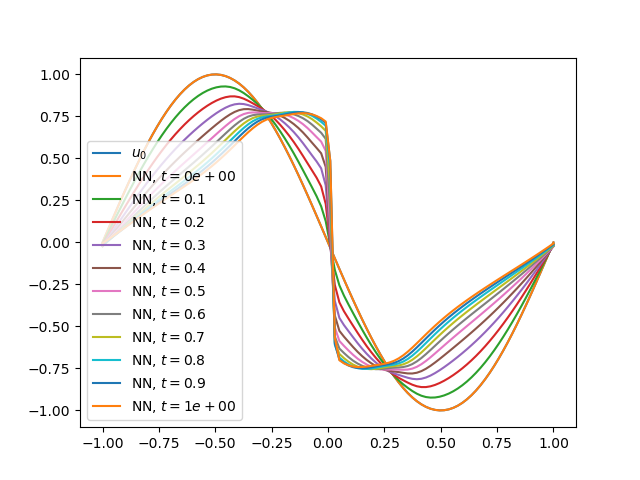

In [19]:
x_vals = torch.linspace(x_min, x_max, 100).reshape(-1, 1)
ones = torch.ones_like(x_vals)
fig, ax = plt.subplots()
ax.plot(x_vals, u_0(x_vals), label=r"$u_0$")
for t in torch.linspace(t_min, t_max, 11):
    u_vals = solution({"t" : t.to('cuda:2')*ones.to('cuda:2'), "x" : x_vals.to('cuda:2')})["u"]
    ax.plot(x_vals.cpu(), u_vals.cpu().detach(), label=f"NN, $t={t:3.1}$")
ax.legend()